**Yongju Kim**  
CMSC 25025 Homework 1: Question 5  
Discussed this assignment with Hyun In Park

**Part (a)**  

In [1]:
# Preliminary setups

import json
import re
import numpy as np
import matplotlib.pyplot as plt  

speech = []

with open("speeches.json") as f:
    
    for line in f:
        speech.append(json.loads(line))
    
    f.close()

In [2]:
def text_edit(text):
    '''
    Edit given text so that prefixes within the text would not include periods.
    
    Input: text (str, pre-edit)
    Returns: text (str, post-edit)
    '''
    to_edit = ["Mr.", "Ms.", "Mrs.", "Dr.", "Hon.", "Prof.", "St.",
               "A.", "B.", "C.", "D.," "E.", "F.", "G.", "H.", "I.", "J.",
               "K.", "L.", "M.", "N.", "O.", "P.", "Q.", "R.", "S.", "T.",
               "U.", "V.", "W.", "X.", "Y.", "Z."]
    
    for case in to_edit:     
        text = re.sub(case, case[:-1], text)
    
    return text

In [3]:
pattern_s = re.compile(r"([A-Z][^\.?!]*[\.?!]+)")

for i in range(len(speech)):
    
    sentence = pattern_s.findall(text_edit(speech[i]["text"]))
    speech[i]["parsed"] = sentence

**Part (b)**  

In [4]:
def regression(data):
    '''
    Conducts regression
    
    Input:
        data (np array): original data
    
    Returns:
        X, Xt (transpose of X), inv (inverse of XtX) in np arrays
    '''   
    X = np.ones(shape = (len(data), 2))
    X[:,1] = data[:,0]
    Xt = np.transpose(X)
    inv = np.linalg.solve(np.matmul(Xt, X), np.identity(2))
    
    return X, Xt, inv

Text(0.5, 1.0, 'Average sentence length (in word count) over years')

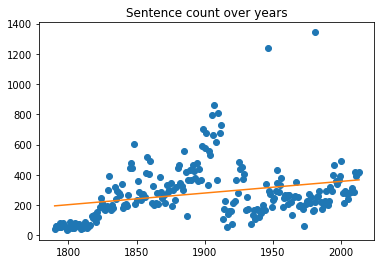

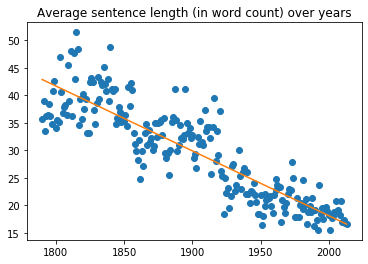

In [5]:
#each row of the array is (year, sentence count,  average length)
data = np.zeros(shape = (len(speech), 3))
pattern_w = re.compile(r"([A-Za-z0-9\$]*[\s.?!,;]+)")

for i in range(len(speech)):
    
    n_sentence = len(speech[i]["parsed"])
    avg_len = np.mean([len(pattern_w.findall(s)) for s in speech[i]["parsed"]])
    data[i] = [speech[i]["year"], n_sentence, avg_len]

data = data[np.argsort(data[:,0])]

X, Xt, inv = regression(data)
beta_count = np.matmul(inv, np.matmul(Xt, data[:,1]))
beta_len = np.matmul(inv, np.matmul(Xt, data[:,2]))

plt.figure(1)
plt.plot(data[:,0], data[:,1], "o")
plt.plot(data[:,0], data[:,0] * beta_count[1] + beta_count[0])
plt.title("Sentence count over years")

plt.figure(2)
plt.plot(data[:,0], data[:,2], "o")
plt.plot(data[:,0], data[:,0] * beta_len[1] + beta_len[0])
plt.title("Average sentence length (in word count) over years")

 The overall trend observable from the plots is that number of sentences in SOU has been increasing, while average length of sentences (in number of words) has been decreasing over time. Still, however, we should be careful when interpreting these plots, as there are obvious outliers in the sentence count data, which might have significantly affected the regression.

**Part (c)**  

Text(0.5, 1.0, 'Total number of words in SOU: 1913 and later')

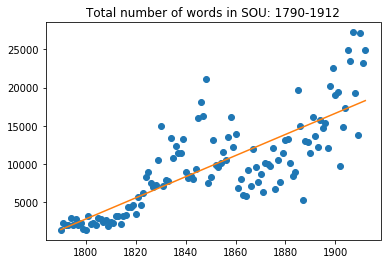

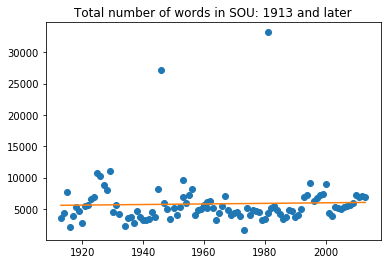

In [6]:
period1, period2 = data[:123], data[123:]
total1 = period1[:,1] * period1[:,2]
total2 = period2[:,1] * period2[:,2]

X1, X1t, inv1 = regression(period1)
X2, X2t, inv2 = regression(period2)

beta_early = np.matmul(inv1, np.matmul(X1t, total1))
beta_modern = np.matmul(inv2, np.matmul(X2t, total2))

plt.figure(3)
plt.plot(period1[:,0], total1, "o")
plt.plot(period1[:,0], period1[:,0] * beta_early[1] + beta_early[0])
plt.title("Total number of words in SOU: 1790-1912")

plt.figure(4)
plt.plot(period2[:,0], total2, "o")
plt.plot(period2[:,0], period2[:,0] * beta_modern[1] + beta_modern[0])
plt.title("Total number of words in SOU: 1913 and later")

From the regression, we can observe that while total number of words in SOU increased significantly until 1912, it suddenly dropped to approx. 5,000 to 6,000 words and remained relatively consistent from 1913 until now. The pattern in the first regression is because SOU was written and sent to the Congress to be read by the clerk since Thomas Jefferson's period till 1913. However, Woodraw Wilson switched to in-person address to the Congress in 1913, and this would not have been effective if the speech is too long. This would explain the smaller total word count since 1913. (source: Wikipedia)

**Part (d)**  

In [7]:
potus = dict()
president_long, president_short = ["", 0], ["", 10000]
sentence_long, sentence_short = ["", 0], ["", 10000]

for sou in speech:
    
    if not sou["president"] in potus:
        potus[sou["president"]] = {"sentences": sou["parsed"], "avg": 0}
    
    else:
        potus[sou["president"]]["sentences"] +=  sou["parsed"]


for case in potus:
    
    len_sum = 0
    
    for sentence in potus[case]["sentences"]:      

        word_len = len(pattern_w.findall(sentence))
        
        if word_len > sentence_long[1]:
            sentence_long = [sentence, word_len]
        
        if word_len < sentence_short[1]:
            sentence_short = [sentence, word_len]
        
        len_sum += word_len
    
    potus[case]["avg"] = len_sum / len(potus[case]["sentences"])
    
    if potus[case]["avg"] > president_long[1]:
        president_long = [case, potus[case]["avg"]]
    
    if potus[case]["avg"] < president_short[1]:
        president_short = [case, potus[case]["avg"]]

length = np.array([potus[case]["avg"] for case in potus])
med = np.median(length)
q25 = np.quantile(length, 0.25)
q75 = np.quantile(length, 0.75)

print('''
      President of longest sentences: {}
      President of shortest sentences: {}
      Longest sentence ever: {}
      Shortest sentence ever: {}
      75% quantile: {:.2f}
      median: {:.2f}
      25% quantile: {:.2f}'''.format(president_long[0], president_short[0],
      sentence_long[0], sentence_short[0], q75, med, q25))


      President of longest sentences: James Madison
      President of shortest sentences: George Bush
      Longest sentence ever: Oer the past 48 months, clear progress has been made in solving the challenges we found in Jnuary of 1977:  

 almost all of our comprehensive energy program have been enacted, and the Department of Energy has been established to administer the program;  

 confidence in the government's integrity has been restored, and respect for the government's openness and fairness has been renewed;  

 the government has been made more effective and efficient: the Cvil Srvice system was completely reformed for the first time this century; 14 reorganization initiatives have been proposed to the Cngress, approved, and implemented; two new Cbinet departments have been created to consolidate and streamline the government's handling of energy and education problems; inspectors general have been placed in each Cbinet department to combat fraud, waste and other abuses; 

It would be reasonable to guess that the shortest sentence above would be a typo of "Government."  
Shortest sentence ever and exact numbers of quantiles would differ depending on the parsing rules. On the other hand, the longest sentence ever (which is significant) and presidents of longest and shortest average sentence length would most probably remain unchanged across various, reasonable parsing rules.